In [1]:
#@title Generic imports
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats
import random

In [2]:
#@title RecSim imports
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

In [3]:
class LTSDocument(document.AbstractDocument):
    def __init__(self, doc_id, kaleness):
        self.kaleness = kaleness
        # doc_id is an integer representing the unique ID of this document
        super(LTSDocument, self).__init__(doc_id)

    def create_observation(self):
        return np.array([self.kaleness])

    @staticmethod
    def observation_space():
        return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
    def __str__(self):
        return "Document {} with kaleness {}.".format(self._doc_id, self.kaleness)

In [4]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
    def __init__(self, doc_ctor=LTSDocument, **kwargs):
        super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
        self._doc_count = 0

    def sample_document(self):
        doc_features = {}
        doc_features['doc_id'] = self._doc_count
        doc_features['kaleness'] = self._rng.random_sample()
        self._doc_count += 1
        return self._doc_ctor(**doc_features)

In [5]:
sampler = LTSDocumentSampler()
for i in range(5): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Document 0 with kaleness 0.5488135039273248.
Document 1 with kaleness 0.7151893663724195.
Document 2 with kaleness 0.6027633760716439.
Document 3 with kaleness 0.5448831829968969.
Document 4 with kaleness 0.4236547993389047.
Documents have observation space: Box(0.0, 1.0, (1,), float32) 
An example realization is:  [0.64589411]


In [6]:
class LTSUserState(user.AbstractUserState):
    def __init__(self, memory_discount, sensitivity, innovation_stddev,
               choc_mean, choc_stddev, kale_mean, kale_stddev,
               net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
              ):
        ## Transition model parameters
        ##############################
        self.memory_discount = memory_discount
        self.sensitivity = sensitivity
        self.innovation_stddev = innovation_stddev

        ## Engagement parameters
        self.choc_mean = choc_mean
        self.choc_stddev = choc_stddev
        self.kale_mean = kale_mean
        self.kale_stddev = kale_stddev

        ## State variables
        ##############################
        self.net_kaleness_exposure = net_kaleness_exposure
        self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
        self.time_budget = time_budget

        # Noise
        self._observation_noise = observation_noise_stddev

    def create_observation(self):
        """User's state is not observable."""
        clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                               1.0 / (1.0 * self._observation_noise))
        noise = stats.truncnorm(
            clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
        noisy_sat = self.satisfaction + noise
        return np.array([noisy_sat,])

    @staticmethod
    def observation_space():
        return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
  
    # scoring function for use in the choice model -- the user is more likely to
    # click on more chocolatey content.
    def score_document(self, doc_obs):
        return 1 - doc_obs

In [7]:
class LTSStaticUserSampler(user.AbstractUserSampler):
    _state_parameters = None

    def __init__(self,
               user_ctor=LTSUserState,
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               kale_mean=4.0,
               kale_stddev=1.0,
               time_budget=60,
               **kwargs):
        self._state_parameters = {'memory_discount': memory_discount,
                                  'sensitivity': sensitivity,
                                  'innovation_stddev': innovation_stddev,
                                  'choc_mean': choc_mean,
                                  'choc_stddev': choc_stddev,
                                  'kale_mean': kale_mean,
                                  'kale_stddev': kale_stddev,
                                  'time_budget': time_budget
                                 }
        super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

    def sample_user(self):
        starting_nke = ((self._rng.random_sample() - .5) *
                        (1 / (1.0 - self._state_parameters['memory_discount'])))
        self._state_parameters['net_kaleness_exposure'] = starting_nke
        return self._user_ctor(**self._state_parameters)

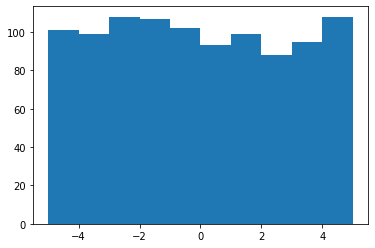

In [8]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
    sampled_user = sampler.sample_user()
    starting_nke.append(sampled_user.net_kaleness_exposure)
_ = plt.hist(starting_nke)

In [9]:
class LTSResponse(user.AbstractResponse):
    # The maximum degree of engagement.
    MAX_ENGAGEMENT_MAGNITUDE = 100.0

    def __init__(self, clicked=False, engagement=0.0):
        self.clicked = clicked
        self.engagement = engagement

    def create_observation(self):
        return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

    @classmethod
    def response_space(cls):
        # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
        return spaces.Dict({
            'click':
                spaces.Discrete(2),
            'engagement':
                spaces.Box(
                    low=0.0,
                    high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                    shape=tuple(),
                    dtype=np.float32)
        })

In [10]:
def user_init(self,
              slate_size,
              seed=0):

    super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
    self.choice_model = MultinomialLogitChoiceModel({})

In [11]:
def simulate_response(self, slate_documents):
    # List of empty responses
    responses = [self._response_model_ctor() for _ in slate_documents]
    # Get click from of choice model.
    self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
    scores = self.choice_model.scores
    selected_index = self.choice_model.choose_item()
    # Populate clicked item.
    self._generate_response(slate_documents[selected_index],
                          responses[selected_index])
    return responses

def generate_response(self, doc, response):
    response.clicked = True
    # linear interpolation between choc and kale.
    engagement_loc = (doc.kaleness * self._user_state.choc_mean
                    + (1 - doc.kaleness) * self._user_state.kale_mean)
    engagement_loc *= self._user_state.satisfaction
    engagement_scale = (doc.kaleness * self._user_state.choc_stddev
                      + ((1 - doc.kaleness)
                          * self._user_state.kale_stddev))
    log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)
    response.engagement = np.exp(log_engagement)

In [12]:
def update_state(self, slate_documents, responses):
    for doc, response in zip(slate_documents, responses):
        if response.clicked:
            innovation = np.random.normal(scale=self._user_state.innovation_stddev)
            net_kaleness_exposure = (self._user_state.memory_discount
                                    * self._user_state.net_kaleness_exposure
                                    - 2.0 * (doc.kaleness - 0.5)
                                    + innovation
                                  )
            self._user_state.net_kaleness_exposure = net_kaleness_exposure
            satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                            * net_kaleness_exposure)
                              )
            self._user_state.satisfaction = satisfaction
            self._user_state.time_budget -= 1
            return

In [13]:
def is_terminal(self):
    """Returns a boolean indicating if the session is over."""
    return self._user_state.time_budget <= 0

In [14]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

In [15]:
slate_size = 3
num_candidates = 10
ltsenv = environment.Environment(
        LTSUserModel(slate_size),
        LTSDocumentSampler(),
        num_candidates,
        slate_size,
        resample_documents=True)

In [16]:
def clicked_engagement_reward(responses):
    reward = 0.0
    for response in responses:
        if response.clicked:
            reward += response.engagement
    return reward

In [17]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [18]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])




# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
doc_id 10 kaleness [0.79172504]
doc_id 11 kaleness [0.52889492]
doc_id 12 kaleness [0.56804456]
doc_id 13 kaleness [0.92559664]
doc_id 14 kaleness [0.07103606]
doc_id 15 kaleness [0.0871293]
doc_id 16 kaleness [0.0202184]
doc_id 17 kaleness [0.83261985]
doc_id 18 kaleness [0.77815675]
doc_id 19 kaleness [0.87001215]
Noisy user state observation
[0.47601281]
Observation 1
Available documents
doc_id 20 kaleness [0.97861834]
doc_id 21 kaleness [0.79915856]
doc_id 22 kaleness [0.46147936]
doc_id 23 kaleness [0.78052918]
doc_id 24 kaleness [0.11827443]
doc_id 25 kaleness [0.63992102]
doc_id 26 kaleness [0.14335329]
doc_id 27 kaleness [0.94466892]
doc_id 28 kaleness [0.52184832]
doc_id 29 kaleness [0.41466194]
User responses to documents in the slate
{'click': 0, 'engagement': array(0.)}
{'click': 1, 'engagement': array(5.32531837)}
{'click': 0, 'engagement': array(0.)}
Noisy user state observation
[0.49696067]


# Agent

In [19]:
# @title Imports
# Generic imports
import functools
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# RecSim imports
from recsim import agent
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym
from recsim.simulator import runner_lib

In [20]:
from recsim.environments import interest_exploration

In [21]:
env_config = {'slate_size': 2,
              'seed': 0,
              'num_candidates': 40,
              'resample_documents': True}
ie_environment = interest_exploration.create_environment(env_config)

In [22]:
initial_observation = ie_environment.reset()

In [23]:
print('User Observable Features')
print(initial_observation['user'])
print('User Response')
print(initial_observation['response'])
print('Document Observable Features')
for doc_id, doc_features in initial_observation['doc'].items():
    print('ID:', doc_id, 'features:', doc_features)

User Observable Features
[]
User Response
None
Document Observable Features
ID: 40 features: {'quality': array(1.19644888), 'cluster_id': 1}
ID: 41 features: {'quality': array(1.28254021), 'cluster_id': 1}
ID: 42 features: {'quality': array(2.01558539), 'cluster_id': 0}
ID: 43 features: {'quality': array(2.46400483), 'cluster_id': 0}
ID: 44 features: {'quality': array(1.33980633), 'cluster_id': 1}
ID: 45 features: {'quality': array(1.11574393), 'cluster_id': 1}
ID: 46 features: {'quality': array(1.46868751), 'cluster_id': 1}
ID: 47 features: {'quality': array(1.42269182), 'cluster_id': 1}
ID: 48 features: {'quality': array(1.21281521), 'cluster_id': 1}
ID: 49 features: {'quality': array(1.29746968), 'cluster_id': 1}
ID: 50 features: {'quality': array(1.33743281), 'cluster_id': 1}
ID: 51 features: {'quality': array(1.15190571), 'cluster_id': 1}
ID: 52 features: {'quality': array(1.34629971), 'cluster_id': 1}
ID: 53 features: {'quality': array(1.24698455), 'cluster_id': 1}
ID: 54 feature

In [24]:
print('Document observation space')
for key, space in ie_environment.observation_space['doc'].spaces.items():
    print(key, ':', space)
print('Response observation space')
print(ie_environment.observation_space['response'])
print('User observation space')
print(ie_environment.observation_space['user'])

Document observation space
40 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
41 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
42 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
43 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
44 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
45 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
46 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
47 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
48 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
49 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
50 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
51 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
52 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), float32))
53 : Dict(cluster_id:Discrete(2), quality:Box(0.0, inf, (), flo

In [25]:
slate = [0, 1]
for slate_doc in slate:
    print(list(initial_observation['doc'].items())[slate_doc])

('40', {'quality': array(1.19644888), 'cluster_id': 1})
('41', {'quality': array(1.28254021), 'cluster_id': 1})


In [26]:
ie_environment.action_space

MultiDiscrete([40 40])

In [27]:
observation, reward, done, _ = ie_environment.step(slate)

In [28]:
observation

{'user': array([], dtype=float64),
 'doc': OrderedDict([('80', {'quality': array(1.31182905), 'cluster_id': 1}),
              ('81', {'quality': array(1.53485104), 'cluster_id': 1}),
              ('82', {'quality': array(1.11880782), 'cluster_id': 1}),
              ('83', {'quality': array(1.03861828), 'cluster_id': 1}),
              ('84', {'quality': array(1.90483927), 'cluster_id': 0}),
              ('85', {'quality': array(1.21476849), 'cluster_id': 1}),
              ('86', {'quality': array(1.85683258), 'cluster_id': 0}),
              ('87', {'quality': array(1.14669338), 'cluster_id': 1}),
              ('88', {'quality': array(1.24551604), 'cluster_id': 1}),
              ('89', {'quality': array(1.16513804), 'cluster_id': 1}),
              ('90', {'quality': array(1.30358862), 'cluster_id': 1}),
              ('91', {'quality': array(1.09084252), 'cluster_id': 1}),
              ('92', {'quality': array(2.05909246), 'cluster_id': 0}),
              ('93', {'quality': ar

In [29]:
from recsim.agent import AbstractEpisodicRecommenderAgent

In [30]:
import numpy as np

In [31]:
#Build RNN as the representation of user’s dynamic preference of recommendations prec
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/Users/zeyu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/Users/zeyu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/Users/zeyu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/pyth

In [119]:
class DqnAgent:
    def __init__(self):
        self.q_net = self._build_dqn_model()
        self.target_q_net = self._build_dqn_model()
    def _build_dqn_model():
        q_net = keras.Sequential()
        q_net.add(Dense(64, input_dim=4, activation='relu', kernel_initializer='he_uniform'))
        q_net.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        q_net.add(Dense(2, activation='linear', kernel_initializer='he_uniform'))
        q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
        return q_net

In [138]:
class StaticAgent(AbstractEpisodicRecommenderAgent):
    def __init__(self, observation_space, action_space):
        # Check if document corpus is large enough.
        self.i=0
        self.observation_space = observation_space
        self.action_space = action_space
        self.RNN_model = keras.Sequential()
        #print((observation_space['doc']))
        if len(observation_space['doc'].spaces) < len(action_space.nvec):
            raise RuntimeError('Slate size larger than size of the corpus.')
        super(StaticAgent, self).__init__(action_space)

    def step(self, reward, observation):
        doc_feature = []
        for doc_id, doc_features in observation['doc'].items():
            #print('ID:', doc_id, 'features:', doc_features)
            doc_feature.append(np.array(doc_features))
        self.doc_feature = np.array(doc_feature)
        if self.i != 0:
            # Old Status S:
            old_user_status  = self.user_status
            old_browsing_history = self.browsing_history
            old_re_hist = self.re_hist
            old_click_id = self.click_id
            old_click_watching_hist = []
            old_click_watching_hist = self.click_watching_hist
            old_ptad = self.ptad
            
            #####
            #New status St+1
            self.user_status = observation['user']
            #Get user's watcing history
            history = []
            for i in list(observation['doc'].values()):
                history.extend(i)
            self.browsing_history = history
            # Get the recommendation history
            re_hist = []
            if observation['response'] == None:
                re_hist.extend(['0', '0'])
            else:
                for i in observation['response']:
                    re_hist.append(i['cluster_id'])
            self.re_hist = re_hist
            # Get which recommedation was clicked by user
            click_watching_hist = []
            click_watching_hist.extend(self.browsing_history)
            click_watching_hist.extend(re_hist)
            # Get p(t)ad
            click_cluster_id = []
            click_list = []
            if observation['response']!=None:
                for q in observation['response']:
                    if q['click']!=0:
                        click_cluster_id.append(q['cluster_id'])
                    else:
                        click_cluster_id.append(-1)
            else:
                click_cluster_id.append(-1)
            self.click_id = click_list
            self.ptad = click_cluster_id
            click_watching_hist.extend(self.ptad)
            click_watching_hist.extend(self.user_status)
            self.click_watching_hist = click_watching_hist
            #print(f'old = {old_click_watching_hist}, new ={click_watching_hist}')
        else:
            #First time
            self.user_status = observation['user']
            #Get user's watcing history
            history = []
            for i in list(observation['doc'].values()):
                history.extend(i)
            self.browsing_history = history
            # Get the recommendation history
            re_hist = []
            if observation['response'] == None:
                re_hist.extend(['-1', '-1'])
            else:
                for i in observation['response']:
                    re_hist.append(i['cluster_id'])
            self.re_hist = re_hist
            # Get which recommedation was clicked by user
            click_id = []
            if observation['response'] == None:
                click_id.append(-1)
                click_id.append(-1)
            else:
                for i in observation['response']:
                    if i['click'] == 0:
                        click_id.append(0)
                    else:
                        click_id.append(i['cluster_id'])
            self.click_id = click_id
            click_watching_hist = []
            click_watching_hist.extend(self.browsing_history)
            click_watching_hist.extend([-1, -1])
            click_watching_hist.extend(click_id)
            click_watching_hist.extend(self.user_status)
            self.click_watching_hist = click_watching_hist
            # Get p(t)ad
            self.ptad = -1
        if self.i == 0:
            self.RNN_model.add(layers.Embedding(input_dim=len(click_watching_hist), output_dim=64))
            self.RNN_model.add(layers.GRU(256, return_sequences=True))
            self.RNN_model.add(layers.SimpleRNN(128))
            self.RNN_model.add(layers.Dense(64))
            self.RNN_model.compile(
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer="sgd",
                metrics=["accuracy"],
            )
            #calculate rect
            num_document_rec = len(self.doc_feature[0])
            n_rec_doc_w = np.array([random.uniform(0, 1) for i in range(num_document_rec)])
            n_rec_doc_b = np.array([random.uniform(0, 1) for i in range(len(observation['doc'].items()))])
            doc_feature = self.doc_feature.T
            rect = np.tanh(np.dot(n_rec_doc_w, doc_feature)+n_rec_doc_b)
            self.n_rec_doc_w = n_rec_doc_w
            self.n_rec_doc_b = n_rec_doc_b
            recomdation = rect.argsort()[-2:][::-1]
            self.recomdation = recomdation
            self.i+=1
            return(list(recomdation))
        else:
            click_cluster_id = []
            click_list = []
            if observation['response']!=None:
                for q in observation['response']:
                    if q['click']!=0:
                        click_cluster_id.append(q['cluster_id'])
                    else:
                        click_cluster_id.append(-1)
            else:
                click_cluster_id.append(-1)
            states = self.RNN_model.fit(
                old_click_watching_hist, click_watching_hist, batch_size=1, epochs=1
            )
            prec = list(self.RNN_model.layers[2].weights[-1].numpy())#prec, pad
            prec.extend(list(self.recomdation))
            # st = prec
            # print(len(st))
            # #Calcualte Q Net:
            # q_net =  DqnAgent()
            # state_input = tf.convert_to_tensor(st, dtype=tf.float32)
            # action_q = q_net.q_net(state_input)
            
            
            
            
            print(prec)
            return(list(self.recomdation))
        #print(observation)

In [139]:
def create_agent(sess, environment, eval_mode, summary_writer=None):
    return StaticAgent(environment.observation_space, environment.action_space)

tmp_base_dir = '/tmp/recsim/'

runner = runner_lib.EvalRunner(
  base_dir=tmp_base_dir,
  create_agent_fn=create_agent,
  env=ie_environment,
  max_eval_episodes=1,
  max_steps_per_episode=5,
  test_mode=True)

In [140]:
seed = 0
np.random.seed(seed)
env_config = {
  'num_candidates': 30,
  'slate_size': 2,
  'resample_documents': True,
  'seed': seed,
  }

In [141]:
from recsim.environments import interest_evolution
from recsim.simulator import runner_lib

In [142]:
from keras.layers import Activation, Dense

In [143]:
tmp_base_dir = 'tmp/'
runner = runner_lib.TrainRunner(
    base_dir=tmp_base_dir,
    create_agent_fn=create_agent,
    env=interest_evolution.create_environment(env_config),
    episode_log_file="base_dir/eval/",
    max_training_steps=50,
    num_iterations=10)
runner.run_experiment()

2022-04-07 23:00:12.968655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-07 23:00:13.284461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-07 23:00:13.404489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


624/624 [==============================] - 11s 15ms/step - loss: 0.7295 - accuracy: 0.9119
[-0.14672115, -0.21708445, -0.10815136, 0.0533668, -0.19440165, -0.036271337, 0.18183234, 0.17078516, 0.17542793, 0.18092827, 0.1805657, -0.16429439, -0.22474511, 0.16742858, 0.10543479, 0.076229796, -0.08416854, -0.16718459, 0.17166659, -0.0065000895, -0.04447981, -0.16079067, -0.14729828, -0.14263041, 0.2059322, -0.016666792, -0.13703825, 0.15795633, -0.027197152, -0.105350345, 0.18262295, -0.21640347, -0.17296192, 0.06969164, 0.15423808, -0.010643802, 0.25069416, 0.1858392, -0.18293618, -0.063956305, -0.16668165, -0.17353275, -0.09984568, -0.023347616, -0.050890695, -0.13659987, 0.19762927, 0.042349447, 0.22017874, 0.11951448, -0.17884468, 0.032371778, -0.09465898, -0.047569074, -0.0919089, 0.08672755, -0.035382483, -0.20417227, -0.0052092997, -0.12103232, 0.2329901, 0.0358365, 0.058464, -0.045617845, 0.14157443, 0.18764354, -0.21502028, 0.0680705, 0.05478522, 0.122407764, -0.07384559, 0.10765

KeyboardInterrupt: 

In [ ]:
runner = runner_lib.EvalRunner(
    base_dir=tmp_base_dir,
    create_agent_fn=create_agent,
    env=interest_evolution.create_environment(env_config),
    max_eval_episodes=5,
    test_mode=True)
runner.run_experiment()

In [881]:
observation, reward, done, _ = ie_environment.step([1])

In [882]:
observation

{'user': array([], dtype=float64),
 'doc': OrderedDict([('680', {'quality': array(1.27011648), 'cluster_id': 1}),
              ('681', {'quality': array(1.15033257), 'cluster_id': 1}),
              ('682', {'quality': array(1.18426715), 'cluster_id': 1}),
              ('683', {'quality': array(1.43637473), 'cluster_id': 1}),
              ('684', {'quality': array(1.03267816), 'cluster_id': 1}),
              ('685', {'quality': array(1.13182232), 'cluster_id': 1}),
              ('686', {'quality': array(1.29367271), 'cluster_id': 1}),
              ('687', {'quality': array(1.99299066), 'cluster_id': 0}),
              ('688', {'quality': array(1.28723461), 'cluster_id': 1}),
              ('689', {'quality': array(1.34061961), 'cluster_id': 1}),
              ('690', {'quality': array(1.41236175), 'cluster_id': 1}),
              ('691', {'quality': array(1.02730772), 'cluster_id': 1}),
              ('692', {'quality': array(1.2054013), 'cluster_id': 1}),
              ('693', {

In [883]:
observation, reward, done, _ = ie_environment.step([1])

In [884]:
observation

{'user': array([], dtype=float64),
 'doc': OrderedDict([('720', {'quality': array(1.0986288), 'cluster_id': 1}),
              ('721', {'quality': array(1.15631395), 'cluster_id': 1}),
              ('722', {'quality': array(1.26735207), 'cluster_id': 1}),
              ('723', {'quality': array(2.22840757), 'cluster_id': 0}),
              ('724', {'quality': array(1.14385049), 'cluster_id': 1}),
              ('725', {'quality': array(1.26234185), 'cluster_id': 1}),
              ('726', {'quality': array(1.283195), 'cluster_id': 1}),
              ('727', {'quality': array(1.25626398), 'cluster_id': 1}),
              ('728', {'quality': array(0.94039086), 'cluster_id': 1}),
              ('729', {'quality': array(1.28147349), 'cluster_id': 1}),
              ('730', {'quality': array(1.20743076), 'cluster_id': 1}),
              ('731', {'quality': array(1.25219683), 'cluster_id': 1}),
              ('732', {'quality': array(2.17716072), 'cluster_id': 0}),
              ('733', {'q

In [91]:
model = keras.Sequential()
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(120, activation='relu'))

In [836]:
class GreedyClusterAgent(agent.AbstractEpisodicRecommenderAgent):
  """Simple agent sorting all documents of a topic according to quality."""

  def __init__(self, observation_space, action_space, cluster_id, **kwargs):
    del observation_space
    super(GreedyClusterAgent, self).__init__(action_space)
    self._cluster_id = cluster_id

    def step(self, reward, observation):
        del reward
        my_docs = []
        my_doc_quality = []
        for i, doc in enumerate(observation['doc'].values()):
            if doc['cluster_id'] == self._cluster_id:
                my_docs.append(i)
                my_doc_quality.append(doc['quality'])
        if not bool(my_docs):
            return []
        sorted_indices = np.argsort(my_doc_quality)[::-1]
        return list(np.array(my_docs)[sorted_indices])

In [37]:
from recsim.agents.layers.cluster_click_statistics import ClusterClickStatsLayer

In [38]:
static_agent = StaticAgent(ie_environment.observation_space,
                           ie_environment.action_space)
static_agent.step(reward, observation)

{'user': array([], dtype=float64), 'doc': OrderedDict([('30', {'quality': array(2.48922445), 'cluster_id': 0}), ('31', {'quality': array(2.12592661), 'cluster_id': 0}), ('32', {'quality': array(1.27448139), 'cluster_id': 1}), ('33', {'quality': array(1.21799112), 'cluster_id': 1}), ('34', {'quality': array(1.17770375), 'cluster_id': 1}), ('35', {'quality': array(2.07948915), 'cluster_id': 0}), ('36', {'quality': array(1.14167652), 'cluster_id': 1}), ('37', {'quality': array(1.20529165), 'cluster_id': 1}), ('38', {'quality': array(1.2424684), 'cluster_id': 1}), ('39', {'quality': array(1.87279668), 'cluster_id': 0}), ('40', {'quality': array(1.19644888), 'cluster_id': 1}), ('41', {'quality': array(1.28254021), 'cluster_id': 1}), ('42', {'quality': array(2.01558539), 'cluster_id': 0}), ('43', {'quality': array(2.46400483), 'cluster_id': 0}), ('44', {'quality': array(1.33980633), 'cluster_id': 1})]), 'response': ({'click': 0, 'quality': array(1.22720163), 'cluster_id': 1}, {'click': 0, 'q

[0, 1]

In [34]:
cluster_static_agent = ClusterClickStatsLayer(StaticAgent,
                                              ie_environment.observation_space,
                                              ie_environment.action_space)
cluster_static_agent.step(reward, observation)

{'user': {'raw_observation': array([], dtype=float64), 'sufficient_statistics': {'impression_count': array([0, 2]), 'click_count': array([0, 0])}}, 'doc': OrderedDict([('30', {'quality': array(2.48922445), 'cluster_id': 0}), ('31', {'quality': array(2.12592661), 'cluster_id': 0}), ('32', {'quality': array(1.27448139), 'cluster_id': 1}), ('33', {'quality': array(1.21799112), 'cluster_id': 1}), ('34', {'quality': array(1.17770375), 'cluster_id': 1}), ('35', {'quality': array(2.07948915), 'cluster_id': 0}), ('36', {'quality': array(1.14167652), 'cluster_id': 1}), ('37', {'quality': array(1.20529165), 'cluster_id': 1}), ('38', {'quality': array(1.2424684), 'cluster_id': 1}), ('39', {'quality': array(1.87279668), 'cluster_id': 0}), ('40', {'quality': array(1.19644888), 'cluster_id': 1}), ('41', {'quality': array(1.28254021), 'cluster_id': 1}), ('42', {'quality': array(2.01558539), 'cluster_id': 0}), ('43', {'quality': array(2.46400483), 'cluster_id': 0}), ('44', {'quality': array(1.33980633

[0, 1]

In [35]:
from recsim.agents.layers.abstract_click_bandit import AbstractClickBanditLayer

In [36]:
class GreedyClusterAgent(agent.AbstractEpisodicRecommenderAgent):
  """Simple agent sorting all documents of a topic according to quality."""

  def __init__(self, observation_space, action_space, cluster_id, **kwargs):
    del observation_space
    super(GreedyClusterAgent, self).__init__(action_space)
    self._cluster_id = cluster_id

  def step(self, reward, observation):
    del reward
    my_docs = []
    my_doc_quality = []
    for i, doc in enumerate(observation['doc'].values()):
      if doc['cluster_id'] == self._cluster_id:
        my_docs.append(i)
        my_doc_quality.append(doc['quality'])
    if not bool(my_docs):
      return []
    sorted_indices = np.argsort(my_doc_quality)[::-1]
    return list(np.array(my_docs)[sorted_indices])

In [37]:
  num_topics = list(ie_environment.observation_space.spaces['doc']
                    .spaces.values())[0].spaces['cluster_id'].n
  base_agent_ctors = [
      functools.partial(GreedyClusterAgent, cluster_id=i)
      for i in range(num_topics)
  ]

In [38]:
bandit_ctor = functools.partial(AbstractClickBanditLayer,
                                arm_base_agent_ctors=base_agent_ctors)
cluster_bandit = ClusterClickStatsLayer(bandit_ctor,
                                        ie_environment.observation_space,
                                        ie_environment.action_space)

In [39]:
observation0 = ie_environment.reset()
slate = cluster_bandit.begin_episode(observation0)
print("Cluster bandit slate 0:")
doc_list = list(observation0['doc'].values())
for doc_position in slate:
  print(doc_list[doc_position])

Cluster bandit slate 0:
{'quality': array(1.46868751), 'cluster_id': 1}
{'quality': array(1.42269182), 'cluster_id': 1}
